## EDA 

This EDA + feature processing has been inspired and influenced by several kernels on kaggle.com:
[kernel 1](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset/code), [kernel 2](https://www.kaggle.com/apapiu/regularized-linear-models/code)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

%matplotlib inline

In [2]:
# set the dataset directory here
input_data_dir='/home/mlisovyi/.kaggle/competitions/house-prices-advanced-regression-techniques/'
train = pd.read_csv(input_data_dir + "/train.csv")
test  = pd.read_csv(input_data_dir + "/test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape

(1460, 81)

One can drop entries with huge living area, as is done in [this kernel](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset/code) and motivated by the [original paper](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf)

In [5]:
# one can drop entries with huge living area, as is done in [this kernel]() and motivated by the original paper
#train = train[train['GrLivArea'] < 4000]

In [6]:
train.shape

(1460, 81)

In [7]:
X = train.drop(['Id', 'SalePrice'], axis=1)
X_subm = test.drop(['Id'], axis=1)
# let's transform y with log(1+x) right away
y = np.log1p(train['SalePrice'])

### Get categorical and numerical columns

Some numbers are in fact categories and vise versa

In [8]:
def convert_cat_num(df):
    for col in ['MoSold', 'MSSubClass']:
        df[col] = df[col].astype(str) + '_str'

In [9]:
convert_cat_num(X)
convert_cat_num(X_subm)

Get the list of cetegorical (`cols_cat`) and numerical (`cols_num`) columns

In [10]:
cols_cat = X.dtypes[X.dtypes == 'object'].index.values
cols_num = X.dtypes[X.dtypes != 'object'].index.values

In [11]:
cols_cat

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'MoSold', 'SaleType', 'SaleCondition'], dtype=object)

In [12]:
cols_num

array(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold'],
      dtype=object)

### Missing values
Count the number of missing values per column

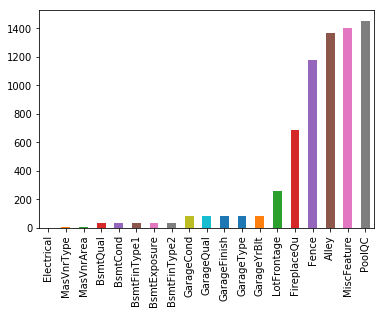

In [13]:
missing = X.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

Most categorical columns have `N/A` representing absence on the object. Let's fill those. There arew some missing values in test sample as well, thus attempt to fill all clumns to avoid customisation

In [14]:
def fill_NA_obvious_cats(df):
    def fill_NA_obvious_cats_set(df, prefix, suff_list):
        '''
        Set NA values for prefix+suff combination
        '''
        for suff in suff_list:
            var_str = prefix + suff
            if var_str in cols_cat:
                fill_val='No'
            else:
                fill_val = 0
            df[var_str].fillna(value=fill_val, inplace=True)
    
    # Do everything together to match nan situation in both train and test sets
    fill_NA_obvious_cats_set(df, '', cols_cat)
    fill_NA_obvious_cats_set(df, '', cols_num)

In [15]:
fill_NA_obvious_cats(X)
fill_NA_obvious_cats(X_subm)

### Store columns that are candidates for LabelEncoding instead of OHE, just in case

In [16]:
cols_le = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
           'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
           'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
           'LotShape', 'PavedDrive', 'Alley']
X_le_orig = X[cols_le]
X_subm_le_orig = X_subm[cols_le]

### Data preprocessing: 
We're not going to do anything fancy here: 
 
- Fill averages within each neighbourhood, where the house is placed
- First I'll transform the skewed numeric features by taking log(feature + 1)    
- Create Dummy variables for the categorical features  

In [17]:
from sklearn.utils import check_array
from sklearn.utils.validation import FLOAT_DTYPES
from sklearn.base import BaseEstimator, TransformerMixin

class AddAverageStats(BaseEstimator, TransformerMixin):
    def __init__ (self, groupby_name, num_cats=None, copy=True):
        self.groupby_name = groupby_name
        self.gbCat_num_mean = None
        self.num_cats = num_cats
        #self.num_cats_idx = None
        self.copy = copy
        
    def _reset(self):
        self.gbCat_num_mean = None
        #self.num_cats_idx = []
        
    def fit(self, X, y=None):
        #self._reset()
        # retrieve numeric columns in the DataFrame if the user did not provide any
        if not self.num_cats:
            self.num_cats = X.dtypes[X.dtypes != 'object'].index.values
        # retrieve the averages in each category        
        self.gbCat_num_mean = (X[np.concatenate([self.num_cats, [self.groupby_name]])]
                                 .groupby(by=self.groupby_name, axis=0)
                                 .mean())
        # return self
        return self
    
    def transform(self, X):
        X = X.copy(deep=True)
        
        # retrieve actual averages for ewquested numeric columns
        for col in self.num_cats:
            X[col + 'AvePer' + self.groupby_name] = (X[self.groupby_name]
                                                   .apply(lambda row: self.gbCat_num_mean.loc[row, col]))
            
        return X

In [18]:
aas = AddAverageStats('Neighborhood')
aas = aas.fit(X)
X = aas.transform(X)
X_subm = aas.transform(X_subm)

In [19]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageCarsAvePerNeighborhood,GarageAreaAvePerNeighborhood,WoodDeckSFAvePerNeighborhood,OpenPorchSFAvePerNeighborhood,EnclosedPorchAvePerNeighborhood,3SsnPorchAvePerNeighborhood,ScreenPorchAvePerNeighborhood,PoolAreaAvePerNeighborhood,MiscValAvePerNeighborhood,YrSoldAvePerNeighborhood
0,60_str,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,Inside,...,2.006667,552.580000,114.320000,51.720000,0.226667,2.593333,4.300000,0.000000,16.333333,2007.806667
1,20_str,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,FR2,...,2.090909,546.909091,190.545455,50.181818,0.000000,0.000000,56.363636,0.000000,0.000000,2007.000000
2,60_str,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,Inside,...,2.006667,552.580000,114.320000,51.720000,0.226667,2.593333,4.300000,0.000000,16.333333,2007.806667
3,70_str,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,Corner,...,1.627451,410.078431,52.568627,27.000000,46.176471,10.803922,30.176471,0.000000,49.019608,2007.490196
4,60_str,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,FR2,...,2.634146,705.926829,200.219512,75.121951,29.243902,0.000000,13.512195,13.536585,0.000000,2007.829268


Do Box-Cox-transform of all numerical columns with significant skew values

In [20]:
skewed_feats = X[cols_num].apply(lambda x: skew(x)) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
print('Features that have been log-transformed: ')
print(skewed_feats.index.values)
skewed_feats = skewed_feats.index


from scipy.special import boxcox1p
lam = 0.15
X[skewed_feats] = boxcox1p(X[skewed_feats], lam)#.astype(np.float32)
X_subm[skewed_feats] = boxcox1p(X_subm[skewed_feats], lam)#.astype(np.float32

Features that have been log-transformed: 
['LotArea' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea'
 'BsmtHalfBath' 'KitchenAbvGr' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal']


Do a log transform as an elternative:

In [21]:
num_skew_BX_015 = np.log1p(X[skewed_feats])
num_skew_BX_015_subm = np.log1p(X_subm[skewed_feats])

Let's dummy-encode categorical features. We do it on the full dataset concatenating `train` and `test` sets. Note, that this is **not fully correct**, as it introduces a data leakage and thus potentially optomistic performance evaluation

In [22]:
all_data = pd.concat([X, X_subm])
all_data = pd.get_dummies(all_data, drop_first=True)
X = all_data.iloc[:X.shape[0], :]
X_subm = all_data.iloc[X.shape[0]:, :]

In [23]:
X.shape

(1460, 325)

## Store data as a dictionary

In [24]:
data={'X': X, 'X_subm': X_subm, 'y': y}

In [25]:
cols_wo_averages = [s for s in X.columns if 'AvePerNeighborhood' not in s]
cols_wo_cat = [s for s in X.columns if ('AvePerNeighborhood' in s or s in cols_num)]
cols_num_only = cols_num

data_wo_averages = {'X': X[cols_wo_averages], 'y': y}
data_wo_cat      = {'X': X[cols_wo_cat], 'y': y}
data_num_only    = {'X': X[cols_num_only], 'y': y}

In [26]:
len(cols_wo_averages)

291

In [27]:
len(cols_wo_cat)

68

In [28]:
len(cols_num_only)

34

### Box Cox transform instead of logarithm

In [29]:
X_skewBC015 = X.copy(deep=True)
#X_subm_altBC = X_subm.copy(deep=True)

X_skewBC015[skewed_feats] = num_skew_BX_015
#X_subm_altBC[skewed_feats] = num_skew_BX_015_subm

data_skewBC015 = {'X': X_skewBC015, 'y': y}

### LabelEncoding instead of OHE for selected columns

In [30]:
cols_le_to_drop = [x for x in X.columns if x.split('_')[0] in cols_le]

In [31]:
qual_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No': 0, 'Av': 3, 'Mn': 2}
live_qual_dict = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No': 0}
funct_dict = {'Maj1':4, 'Maj2':5, 'Min1':1, 'Min2':2, 'Mod':3, 'Sev':6, 'Typ':0, 'Sal':7}
garFin_dict = {'Fin':3, 'No':0, 'RFn':2, 'Unf':1}
lanSlope_dict = {'Gtl':3, 'Mod':2, 'Sev':1, 'No':0}
lotShape_dict = {'IR1':1, 'IR2':2, 'IR3':3, 'Reg':0}
pavedDrive_dict = {'N':0, 'P':1, 'Y':2}
alley_dict = {'Grvl':1, 'No':0, 'Pave':2}

In [32]:
cols_le_qual = ['FireplaceQu', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
                'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual']
cols_le_live = ['BsmtFinType1', 'BsmtFinType2']


In [33]:
X_le = X.drop(cols_le_to_drop, axis=1)

In [34]:
# process columns, apply LabelEncoder to categorical features
for c in cols_le_qual:
    X_le[c] = X_le_orig[c].map(qual_dict).astype(np.uint8)
    
for c in cols_le_live:
    X_le[c] = X_le_orig[c].map(live_qual_dict).astype(np.uint8)
    
X_le['Functional'] = X_le_orig['Functional'].map(funct_dict).astype(np.uint8)

X_le['GarageFinish'] = X_le_orig['GarageFinish'].map(garFin_dict).astype(np.uint8)

X_le['LandSlope'] = X_le_orig['LandSlope'].map(lanSlope_dict).astype(np.uint8)

X_le['LotShape'] = X_le_orig['LotShape'].map(lotShape_dict).astype(np.uint8)

X_le['PavedDrive'] = X_le_orig['PavedDrive'].map(pavedDrive_dict).astype(np.uint8)

X_le['Alley'] = X_le_orig['Alley'].map(alley_dict).astype(np.uint8)

In [35]:
data_le = {'X': X_le, 'y': y}

## Get a reduced dataset based on the RandomForest importance estimate

In [36]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, max_features=0.6, random_state=314)
model.fit(X,y)
feat_imp = pd.Series(model.feature_importances_, index=X.columns)

In [37]:
best_feat_10 = feat_imp.nlargest(10)
best_feat_20 = feat_imp.nlargest(20)
best_feat_40 = feat_imp.nlargest(40)

In [38]:
data_RF_best10 = {'X': X[best_feat_10.index], 'y': y}
data_RF_best20 = {'X': X[best_feat_20.index], 'y': y}
data_RF_best40 = {'X': X[best_feat_40.index], 'y': y}

Let's drow how top-10 categories look like

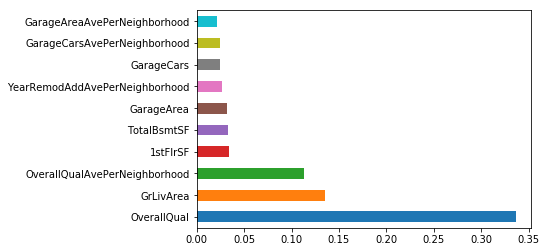

In [39]:
best_feat_10.plot(kind='barh')

The averages over numeric categories seem to be useful

However, if we would use a LightGBM model instead we would get a different list:

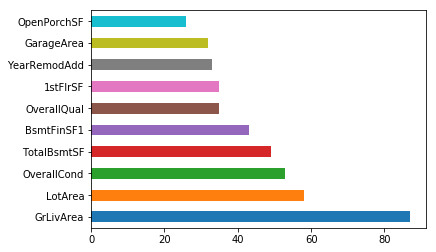

In [40]:
import lightgbm as lgb
model = lgb.LGBMRegressor(max_depth=4, random_state=314, num_leaves=40, colsample_bytree=0.6).fit(X, y)
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='barh')

The GBM has a different view on what variables are important

## Get a reduced dataset from X based on RFE

In [41]:
from sklearn.feature_selection import RFE

feat_sels = {}

models = {'LGB_depthINF_cols06_nleaves20':   lgb.LGBMRegressor(max_depth=-1, random_state=314, num_leaves=20, colsample_bytree=0.6)}
for model_name in models:
    feat_selector = RFE(models[model_name], n_features_to_select=30, step=10, verbose=0)
    feat_selector.fit(X,y)
    feat_sels[model_name] = feat_selector

In [42]:
mask = feat_sels['LGB_depthINF_cols06_nleaves20'].support_

In [43]:
X.columns[mask]

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'Fireplaces',
       'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'OverallQualAvePerNeighborhood',
       'BsmtFullBathAvePerNeighborhood', 'BsmtHalfBathAvePerNeighborhood',
       'BedroomAbvGrAvePerNeighborhood', 'FireplacesAvePerNeighborhood',
       'GarageYrBltAvePerNeighborhood', 'WoodDeckSFAvePerNeighborhood',
       'EnclosedPorchAvePerNeighborhood', 'SaleCondition_Normal'],
      dtype='object')

## Get a reduced dataset from X with ordered label-encoded features based on RFE

In [44]:
feat_sels_le = {}

for model_name in models:
    feat_selector = RFE(models[model_name], n_features_to_select=30, step=10, verbose=0)
    feat_selector.fit(X_le,y)
    feat_sels_le[model_name] = feat_selector

In [45]:
mask = feat_sels_le['LGB_depthINF_cols06_nleaves20'].support_

In [46]:
X_le.columns[mask]

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'YrSold',
       'OverallQualAvePerNeighborhood', 'YearRemodAddAvePerNeighborhood',
       'BsmtFinSF1AvePerNeighborhood', 'BsmtUnfSFAvePerNeighborhood',
       'FireplacesAvePerNeighborhood', 'WoodDeckSFAvePerNeighborhood',
       'YrSoldAvePerNeighborhood', 'SaleCondition_Normal', 'BsmtExposure',
       'KitchenQual', 'BsmtFinType1'],
      dtype='object')

## Define data transformations

In [47]:
Ncols = data['X'].shape[1]
Ncols_half = int(Ncols / 2)
Ncols_quat = int(Ncols / 4)
Ncols_mini = int(Ncols / 10)
Ncols_nano = int(Ncols / 30)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA, FastICA
transforms = {'raw': None,
              'rs_pca_quat' : make_pipeline(RobustScaler(), PCA(svd_solver='full',  n_components=Ncols_quat)),
              #'pca_trunc': PCA(svd_solver='full',  n_components='mle'),
              #'pca_half' : PCA(svd_solver='full',  n_components=Ncols_half),
              'pca_quat' : PCA(svd_solver='full',  n_components=Ncols_quat)}#,
              #'pca_nano' : PCA(svd_solver='full',  n_components=Ncols_nano)}
    
#transforms = {'raw': None}

scalers = {#'StandardScaler': StandardScaler(),
           'RobustScaler': RobustScaler()}
           #'MinMaxScaler': MinMaxScaler()}

In [48]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoLars
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR, SVR
import xgboost as xgb
import lightgbm as lgb

In [49]:
models = {#'knn3': KNeighborsRegressor(n_neighbors=3), 
          'knn5_p1':  KNeighborsRegressor(n_neighbors=5, p=1), 
          'knn5':  KNeighborsRegressor(n_neighbors=5), 
          #'knn7':  KNeighborsRegressor(n_neighbors=7),
          #'LinReg':  LinearRegression(),                  
          #'LinRegL1_1':  Lasso(alpha=1, random_state=314),
          'LinRegL1_01':  Lasso(alpha=0.1, random_state=314),
          'LinRegL1_5em4': Lasso(alpha =0.0005, random_state=314),
          #'LinRegL1_001':  Lasso(alpha=0.01, random_state=314),
          #'LinRegL2_1': Ridge(alpha=1, random_state=314),
          #'LinRegL2_01': Ridge(alpha=0.1, random_state=314),
          'LinRegL2_001': Ridge(alpha=0.01, random_state=314),
          'LinRegL2_10': Ridge(alpha=10, random_state=314),
          #'RbfSVR': SVR(),
          #'LinearSVR' : LinearSVR()}#,
          #'XGB_depth5':  xgb.XGBRegressor(max_depth=5, random_state=314, silent=True),
          #'XGB_depth7':  xgb.XGBRegressor(max_depth=7, random_state=314, silent=True),
          #'LGB_depth5':   lgb.LGBMRegressor(max_depth=5, random_state=314),
          #'LGB_depth7':   lgb.LGBMRegressor(max_depth=7, random_state=314),
          'RandomF_maxF03': RandomForestRegressor(n_estimators=100, max_features=0.3, n_jobs=-1, random_state=314),
          'RandomF_maxF06': RandomForestRegressor(n_estimators=100, max_features=0.6, n_jobs=-1, random_state=314),
          'RandomF_maxF06_nest200': RandomForestRegressor(n_estimators=200, max_features=0.6, n_jobs=-1, random_state=314),
          'ExtraF_maxF03_depth7':  ExtraTreesRegressor  (n_estimators=100, max_features=0.3, max_depth=7, n_jobs=-1, random_state=314),
          'ExtraF_maxF03_depth5':  ExtraTreesRegressor  (n_estimators=100, max_features=0.3, max_depth=5, n_jobs=-1, random_state=314),
          'LGB_depthINF_cols06_nleaves5':    lgb.LGBMRegressor(max_depth=-1, random_state=314, num_leaves=5, colsample_bytree=0.6),
          #'LGB_depthINF_cols06_nleaves10':   lgb.LGBMRegressor(max_depth=-1, random_state=314, num_leaves=10, colsample_bytree=0.6),
          'LGB_depthINF_cols06_nleaves20':   lgb.LGBMRegressor(max_depth=-1, random_state=314, num_leaves=20, colsample_bytree=0.6),
          'LGB_depth7_cols01':   lgb.LGBMRegressor(max_depth=7, random_state=314, colsample_bytree=0.1),
          #'LGB_depth7_cols03':   lgb.LGBMRegressor(max_depth=7, random_state=314, colsample_bytree=0.3),
          'LGB_depth7_cols06':   lgb.LGBMRegressor(max_depth=7, random_state=314, colsample_bytree=0.6)}#,
          #'LGB_depth7_cols08':   lgb.LGBMRegressor(max_depth=7, random_state=314, colsample_bytree=0.8)}
    
#models = {'LinRegL1_01':  Lasso(alpha=0.1, random_state=314),
#          'LinRegL1_5em4': Lasso(alpha =0.0005, random_state=1)}

In [50]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate

# Define error measure for official scoring : MSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

Make a list of all transforms that we want to evaluate

In [51]:
transforms_full = list(transforms)

for s in scalers:
    for t in transforms:
        transforms_full.append(t + '_' + s)

In [52]:
import pickle

model_names = sorted(models.keys())

acc_valid_cv_summary = pd.DataFrame(index=model_names, columns=transforms_full, dtype=np.float32)
var_valid_cv_summary = pd.DataFrame(index=model_names, columns=transforms_full, dtype=np.float32)
acc_train_cv_summary = pd.DataFrame(index=model_names, columns=transforms_full, dtype=np.float32)
fit_time_cv_summary  = pd.DataFrame(index=model_names, columns=transforms_full, dtype=np.float32)

pred_subm = pd.DataFrame(dtype=np.float32)

def benchmarkModelsCV(df_dict, transform_name='', save_preds=False):
    for clf_name, clf in models.items():
        #print(clf_name)
        #list of steps for the pipeline
        steps = []
        # add transformations, that are needed
        for t_name in transforms.keys():
            if t_name in transform_name:
                steps.append((t_name, transforms[t_name]))
        # add scalers that are needed
        for s_name in scalers.keys():
            if s_name in transform_name:
                steps.append((s_name, scalers[s_name]))
        # add the classifier as the last element in the chain
        steps.append(('clf', clf))
        # construct a pipeline out of prepared transforms and clf
        pipe = Pipeline(steps=steps)
        # Let's run cross validation on the prepared pipeline
        # Note, that  we run it on the full train sample:
        # this increases statistics and we do not need the valid sample, 
        # as we do not plan to to HP optimisation for this study
        score = cross_validate(pipe,
                               X = df_dict['X'], 
                               y = df_dict['y'],
                               scoring='neg_mean_squared_error',
                               cv=5, 
                               return_train_score=True)
        # save evaluated performance results
        x = -1*score['test_score']
        x = x[x<100]
        acc_valid_cv_summary.loc[clf_name, transform_name] = np.sqrt(x).mean()
        var_valid_cv_summary.loc[clf_name, transform_name] = np.sqrt(x).std()
        x = -1*score['train_score']
        x = x[x<100]
        acc_train_cv_summary.loc[clf_name, transform_name] = np.sqrt(x).mean()
        fit_time_cv_summary.loc[clf_name, transform_name] = score['fit_time'].mean()
        # train the pipeline on the full dataset and predict on the submission test sample
        if save_preds:
            pipe.fit(X = df_dict['X'],
                     y = df_dict['y'])
            preds = pipe.predict(df_dict['X_subm'])
            pred_subm['{}_{}'.format(transform_name, clf_name)] = preds

In [53]:
save_preds = True
for t_name in transforms_full:
    print('========== ', t_name,' =====================')
    benchmarkModelsCV(data, t_name, save_preds)
    
if save_preds:
    pickle.dump(pred_subm, open( "data/pred_{}.pickle".format('v0'), "wb" ))

==========  rs_pca_quat  =====================
==========  raw  =====================


/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordin

==========  pca_quat  =====================
==========  rs_pca_quat_RobustScaler  =====================
==========  raw_RobustScaler  =====================
==========  pca_quat_RobustScaler  =====================


In [54]:
def plotPerformance(perf_df, title='', vmin=None, vmax=None, cmap='Blues', figsize=(15,6), ax=None):
    if ax is not None:
        plt.figure(figsize=figsize)
    _ = sns.heatmap(perf_df, cmap=cmap, annot=True, vmin=vmin, vmax=vmax, ax=ax, fmt='.3g')
    if not ax:
        plt.title(title)
    else:
        ax.set_title(title)
    
def makeStandardPlots(titleSuffix='', two_by_two=False):
    n_cols = 1
    n_rows = 4
    sub_figsize = (15,6)
    figsize = (16,24)
    if two_by_two:
        n_cols = 2
        n_rows = 2
        sub_figsize = (8,4)
        figsize = (16,10)
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    ax = ax.ravel()
    if two_by_two:
        fig.subplots_adjust(wspace=0.5, hspace=0.5)
    else:
        fig.subplots_adjust(hspace=0.3)

    plotPerformance(acc_train_cv_summary, title='Training RMSE averaged {}'.format(titleSuffix), vmin=0.1, vmax=0.16, figsize=sub_figsize , ax=ax[0])
    plotPerformance(acc_valid_cv_summary, title='Validation RMSE averaged {}'.format(titleSuffix), vmin=0.1, vmax=0.16, figsize=sub_figsize, ax=ax[1])
    plotPerformance(var_valid_cv_summary, title='Validation RMSE std var {}'.format(titleSuffix), vmin=0, vmax=0.025, cmap='Greens', figsize=sub_figsize, ax=ax[2])
    plotPerformance(fit_time_cv_summary, title='Fit TIME average, sec {}'.format(titleSuffix), vmin=0, vmax=0.5, cmap='Oranges', figsize=sub_figsize, ax=ax[3])                 

In [55]:
acc_valid_cv_summary

,rs_pca_quat,raw,pca_quat,rs_pca_quat_RobustScaler,raw_RobustScaler,pca_quat_RobustScaler
ExtraF_maxF03_depth5,0.251119,0.173897,0.253431,0.251119,0.173897,0.253353
ExtraF_maxF03_depth7,0.219461,0.156412,0.222660,0.219461,0.156412,0.222596
LGB_depth7_cols01,0.179861,0.130196,0.182320,0.181092,0.129949,0.183005
LGB_depth7_cols06,0.157165,0.127381,0.157321,0.155115,0.126557,0.156933
LGB_depthINF_cols06_nleaves20,0.155438,0.126955,0.154388,0.153267,0.127509,0.155648
LGB_depthINF_cols06_nleaves5,0.161655,0.128530,0.164232,0.160556,0.128685,0.164528
LinRegL1_01,0.229953,0.202457,0.192491,0.281772,0.236366,0.292476
LinRegL1_5em4,0.130972,0.127681,0.132860,0.130850,0.127422,0.132890
LinRegL2_001,0.130926,0.156532,0.133115,0.130927,0.156531,0.133115
LinRegL2_10,0.130663,0.127930,0.132858,0.130857,0.127740,0.133014


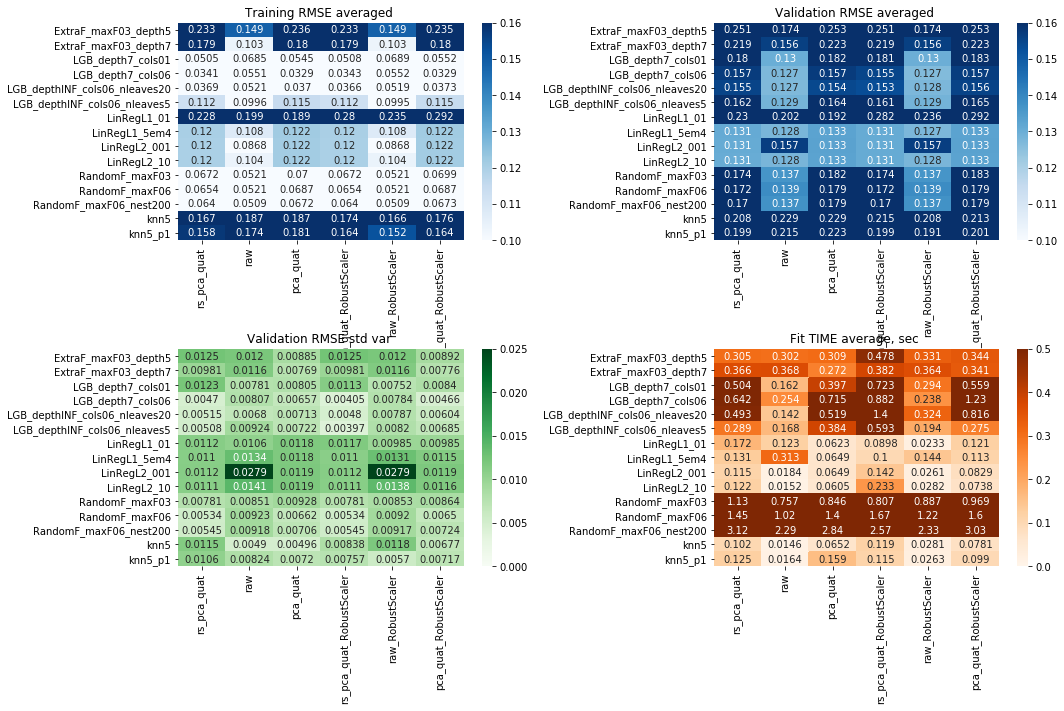

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

In [56]:
makeStandardPlots(two_by_two=True)

In [57]:
pred_subm = pred_subm.reindex(sorted(pred_subm.columns), axis=1)

In [58]:
pred_subm.head()

,pca_quat_ExtraF_maxF03_depth5,pca_quat_ExtraF_maxF03_depth7,pca_quat_LGB_depth7_cols01,pca_quat_LGB_depth7_cols06,pca_quat_LGB_depthINF_cols06_nleaves20,pca_quat_LGB_depthINF_cols06_nleaves5,pca_quat_LinRegL1_01,pca_quat_LinRegL1_5em4,pca_quat_LinRegL2_001,pca_quat_LinRegL2_10,...,rs_pca_quat_RobustScaler_LinRegL1_5em4,rs_pca_quat_RobustScaler_LinRegL2_001,rs_pca_quat_RobustScaler_LinRegL2_10,rs_pca_quat_RobustScaler_RandomF_maxF03,rs_pca_quat_RobustScaler_RandomF_maxF06,rs_pca_quat_RobustScaler_RandomF_maxF06_nest200,rs_pca_quat_RobustScaler_knn5,rs_pca_quat_RobustScaler_knn5_p1,rs_pca_quat_knn5,rs_pca_quat_knn5_p1
0,11.966804,11.932699,11.778436,11.880005,11.858748,11.845951,11.934457,11.713422,11.697719,11.705341,...,11.680352,11.674105,11.679064,11.802766,11.830383,11.845610,11.970895,11.899987,12.011673,11.820567
1,11.938988,11.897608,11.984234,11.846585,11.912417,11.911907,11.800566,11.907605,11.916000,11.915759,...,11.923952,11.925617,11.928446,11.867604,11.874149,11.875311,12.015079,11.826830,12.011137,11.916076
2,12.047586,12.082617,12.019290,12.068291,12.077181,12.011256,12.186407,12.104828,12.107827,12.109010,...,12.099375,12.095504,12.094991,12.104594,12.112899,12.098935,12.091954,12.096326,12.112507,12.112507
3,12.054333,12.100964,12.073357,12.124591,12.163134,12.079802,12.193995,12.235196,12.242040,12.240837,...,12.230287,12.232728,12.231309,12.175855,12.175782,12.180518,12.125756,12.119522,12.136932,12.136061
4,12.298667,12.331957,12.147057,12.131311,12.183969,12.152979,12.357489,12.238531,12.231637,12.234522,...,12.220793,12.216749,12.216709,12.311466,12.348514,12.327727,12.404852,12.333181,12.456816,12.459059


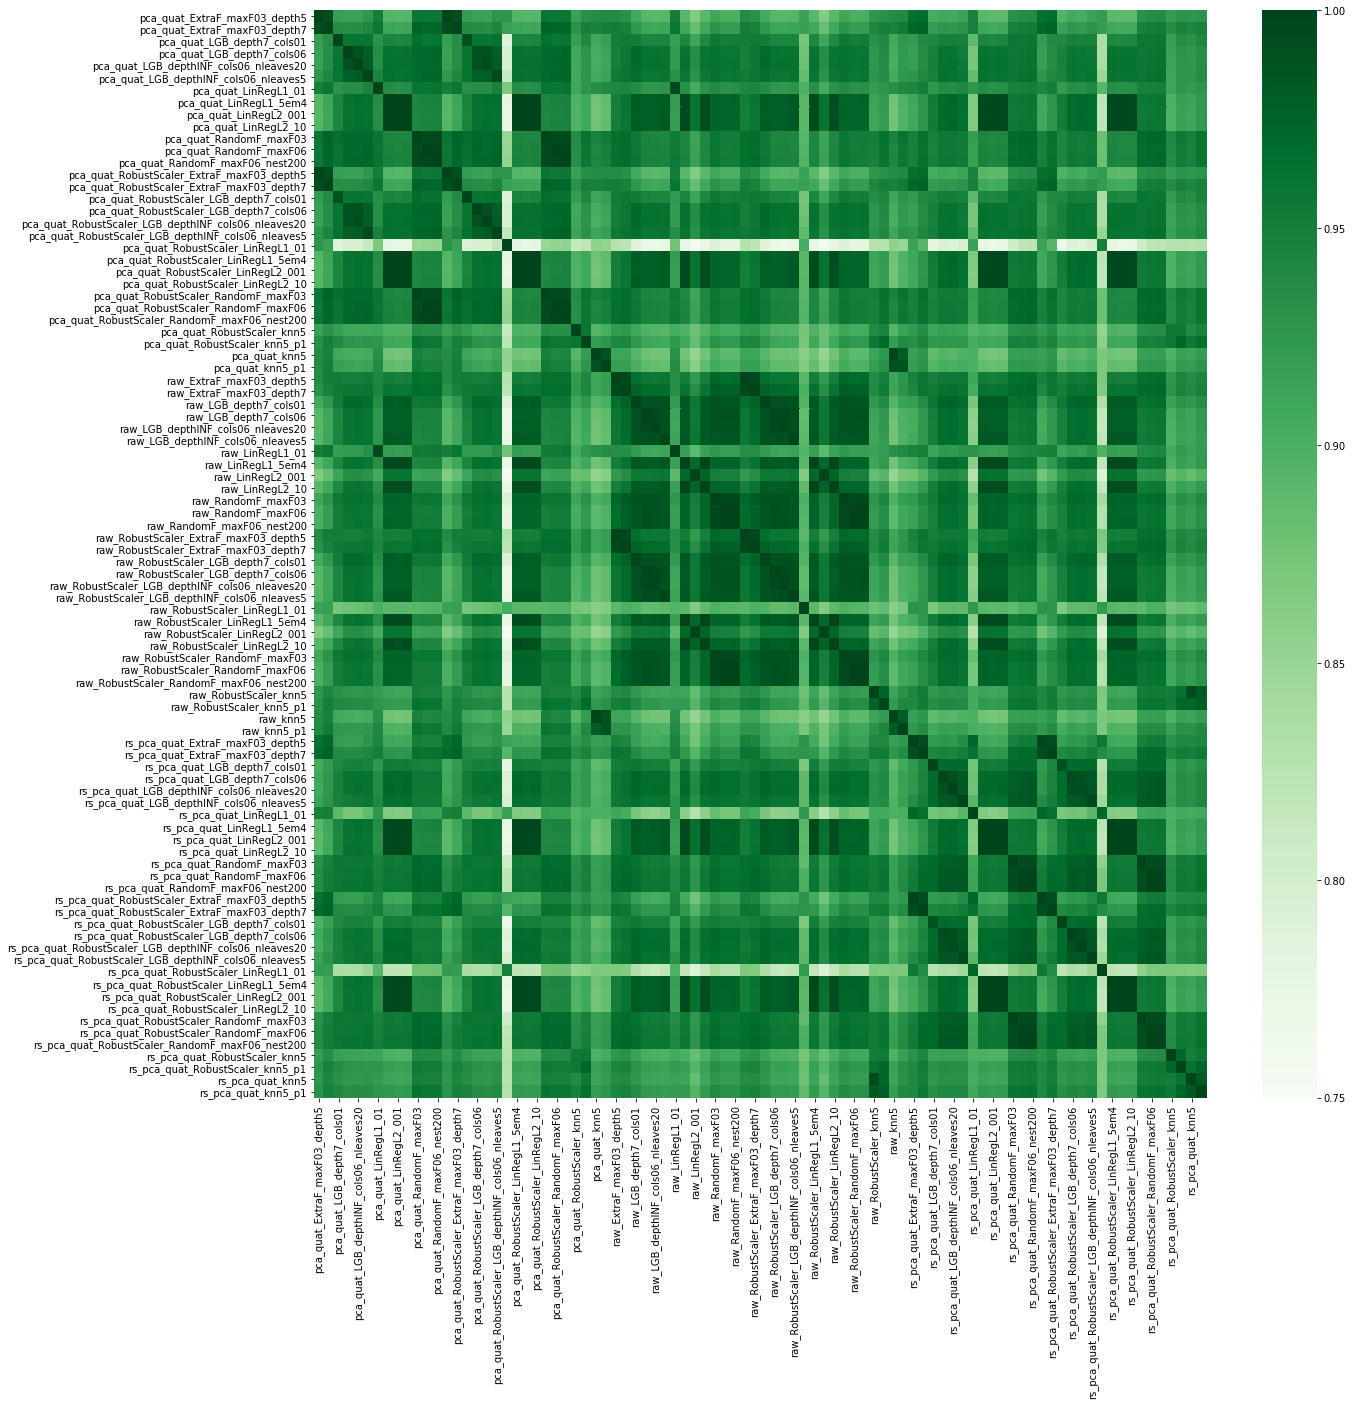

In [59]:
plt.figure(figsize=(20,20))
sns.heatmap(pred_subm.corr(), cmap='Greens', vmin=0.75)

# Test subsets of input data in terms of features used

==========  rs_pca_quat  =====================
==========  raw  =====================
==========  pca_quat  =====================
==========  rs_pca_quat_RobustScaler  =====================
==========  raw_RobustScaler  =====================
==========  pca_quat_RobustScaler  =====================


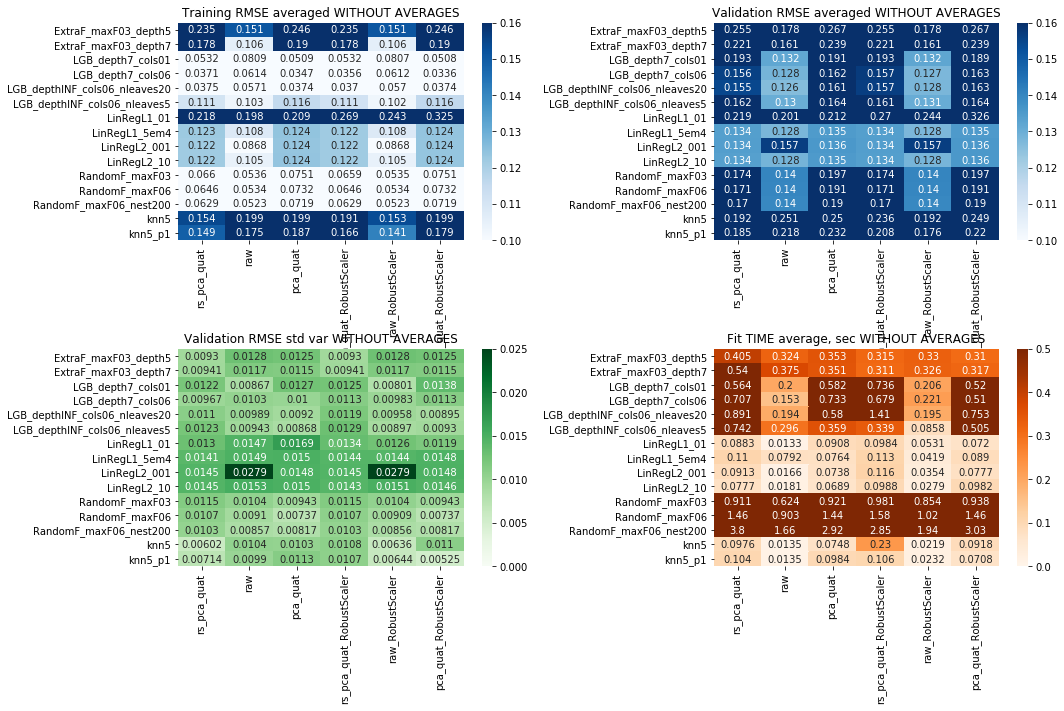

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

In [60]:
save_preds = False
for t_name in transforms_full:
    print('========== ', t_name,' =====================')
    benchmarkModelsCV(data_wo_averages, t_name, save_preds)
    
makeStandardPlots(two_by_two=True, titleSuffix='WITHOUT AVERAGES')

==========  raw  =====================


/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordin

==========  raw_RobustScaler  =====================


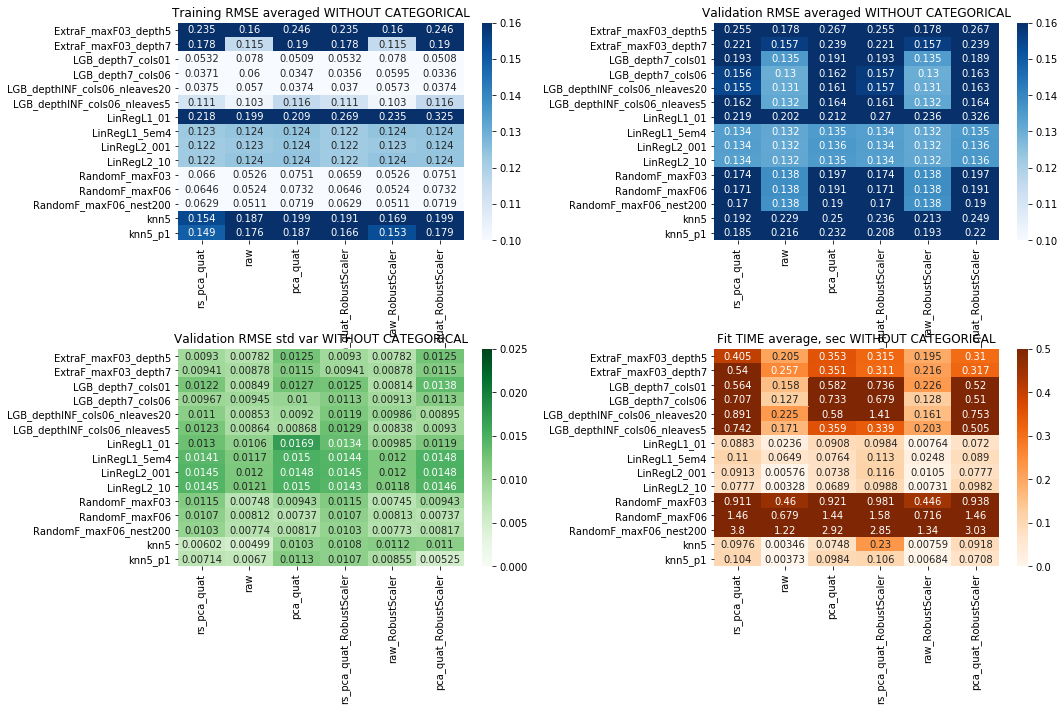

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

In [61]:
save_preds = False
for t_name in transforms_full:
    if 'pca' in t_name:
        continue
    print('========== ', t_name,' =====================')
    benchmarkModelsCV(data_wo_cat, t_name, save_preds)

makeStandardPlots(two_by_two=True, titleSuffix='WITHOUT CATEGORICAL')

==========  raw  =====================
==========  raw_RobustScaler  =====================


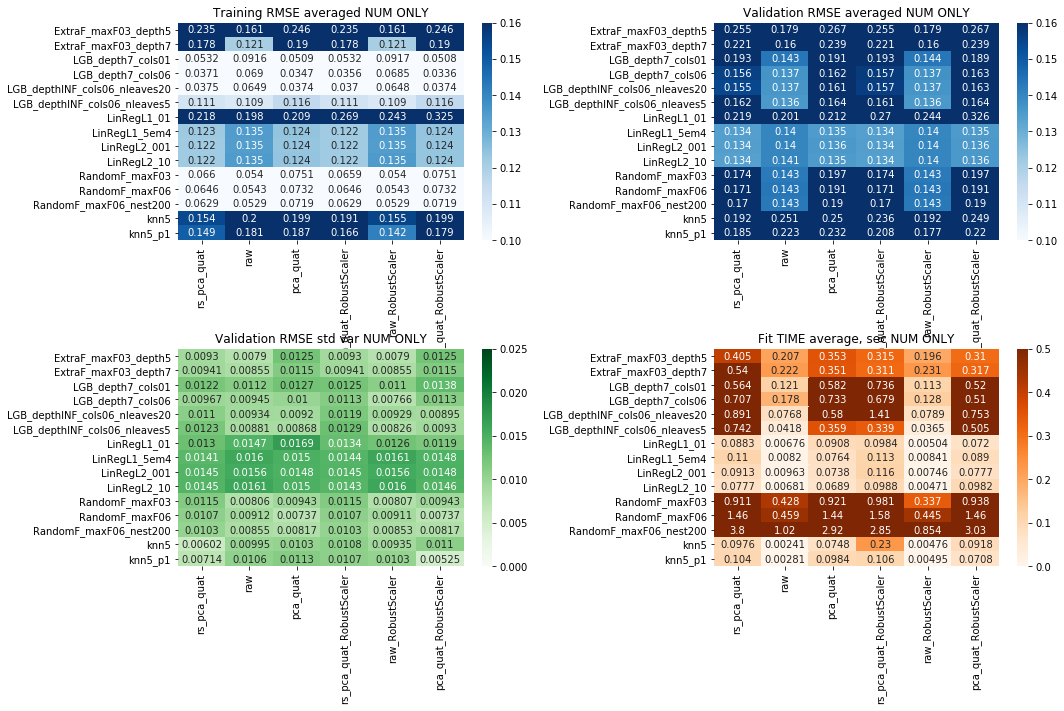

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

In [62]:
save_preds = False
for t_name in transforms_full:
    if 'pca' in t_name:
        continue
    print('========== ', t_name,' =====================')
    benchmarkModelsCV(data_num_only, t_name, save_preds)
    
makeStandardPlots(two_by_two=True, titleSuffix='NUM ONLY')

==========  raw  =====================
==========  raw_RobustScaler  =====================


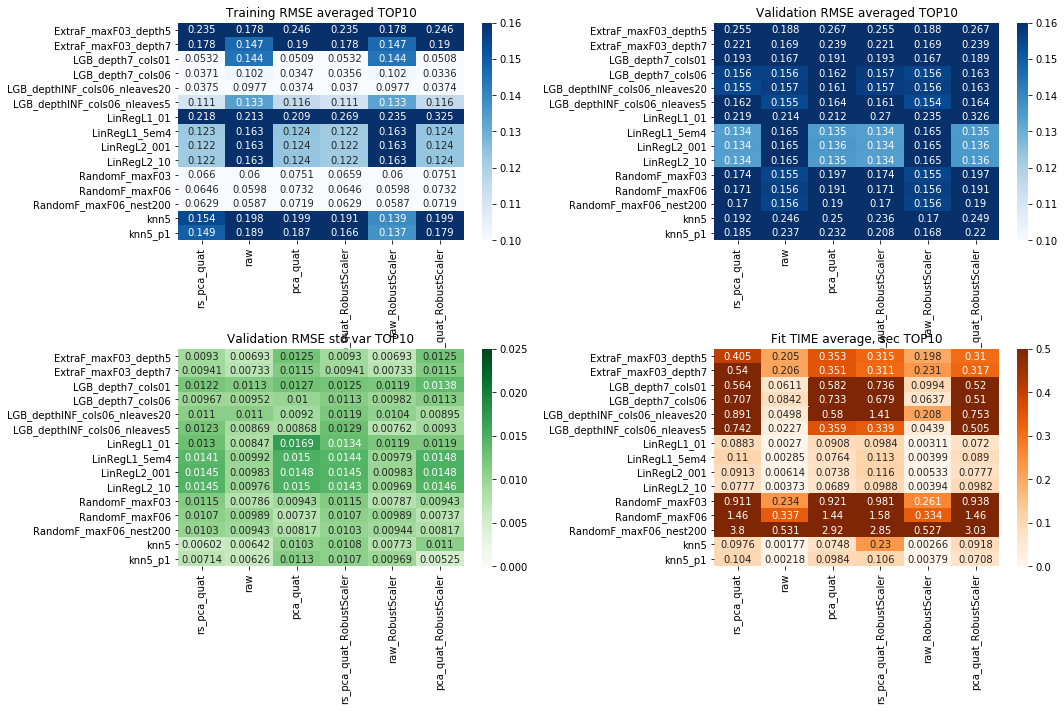

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

In [63]:
save_preds = False
for t_name in transforms_full:
    if 'pca' in t_name:
        continue
    print('========== ', t_name,' =====================')
    benchmarkModelsCV(data_RF_best10, t_name, save_preds)
    
if save_preds:
    pickle.dump(pred_subm, open( "data/pred_{}.pickle".format('v0'), "wb" ))
    
makeStandardPlots(two_by_two=True, titleSuffix='TOP10')

==========  raw  =====================
==========  raw_RobustScaler  =====================


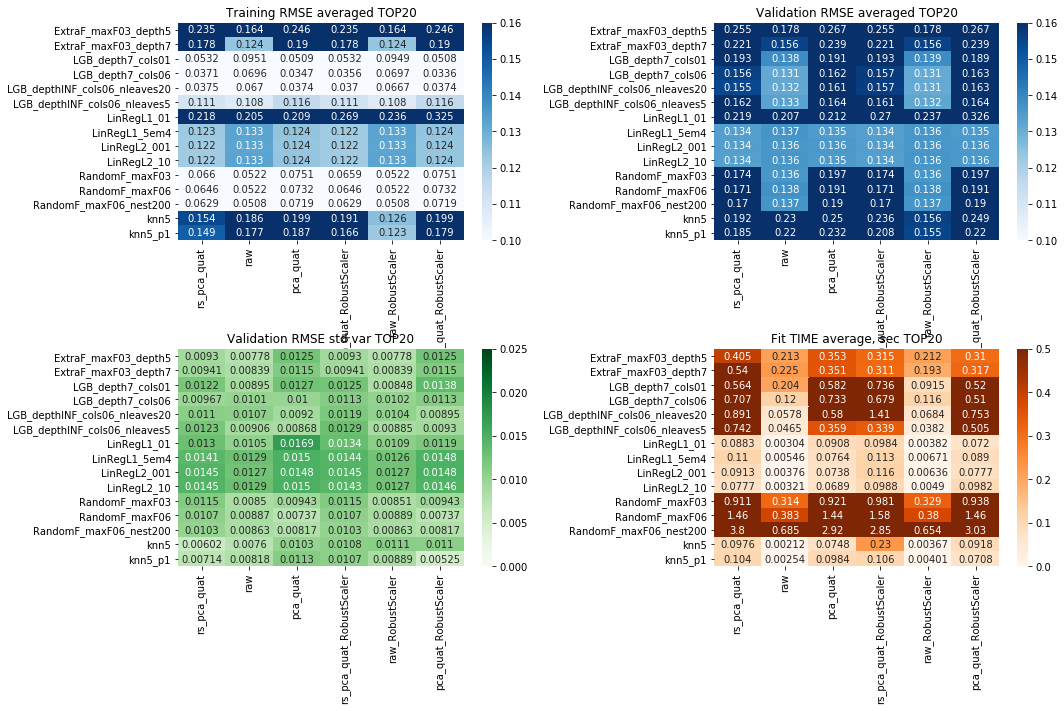

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

In [64]:
save_preds = False
for t_name in transforms_full:
    if 'pca' in t_name:
        continue
    print('========== ', t_name,' =====================')
    benchmarkModelsCV(data_RF_best20, t_name, save_preds)
    
makeStandardPlots(two_by_two=True, titleSuffix='TOP20')

==========  raw  =====================


/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordin

==========  raw_RobustScaler  =====================


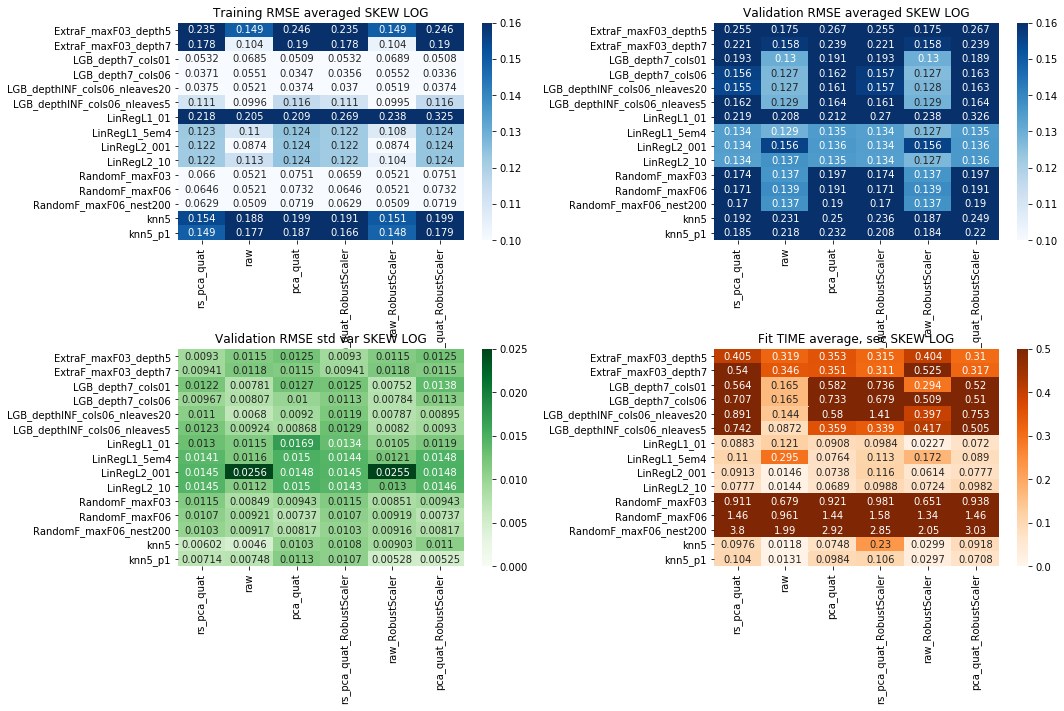

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

In [65]:
save_preds = False
for t_name in transforms_full:
    if 'pca' in t_name:
        continue
    print('========== ', t_name,' =====================')
    benchmarkModelsCV(data_skewBC015, t_name, save_preds)
    
makeStandardPlots(two_by_two=True, titleSuffix='SKEW LOG')

==========  raw  =====================


/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/linear_model/coordin

==========  raw_RobustScaler  =====================


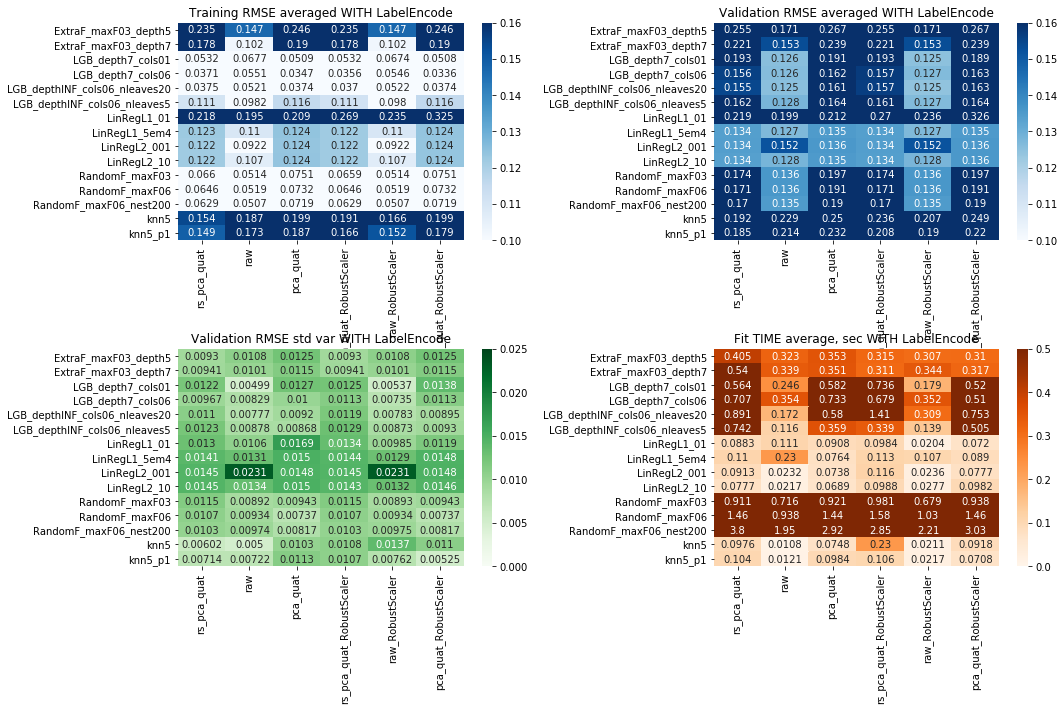

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

In [66]:
save_preds = False
for t_name in transforms_full:
    if 'pca' in t_name:
        continue
    print('========== ', t_name,' =====================')
    benchmarkModelsCV(data_le, t_name, save_preds)
    
makeStandardPlots(two_by_two=True, titleSuffix='WITH LabelEncode')